In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import csv
from scipy.signal import resample_poly

from pathlib import Path
import glob
import shutil
import os
import pickle

import sys
sys.path.append('/storage3/eva/code/remapping/src')
import path_formatting as pf
import motive
import utils
import oe

In [2]:
date = "20250915" # change this according to ur session
animal = "eb03"

oe_sr = 30000
m_sr = 120

_, ks_path, csv_path, res_path = utils.path_load(date, animal,p=True)

pf_path = Path(res_path) / "pf"
pf_path.mkdir(parents=True, exist_ok=True) # Create the folder if it doesn't exist

csv_path, ks_path, res_path, pf_path

Ola! For folders inside of res_path: Path(res_path)/"folder_name"
To make new folder (if not exist): your_path.mkdir(parents=True, exist_ok=True)


('/storage3/eva/data/processed/eb03/eb03_20250915/motive/out_csv',
 '/storage3/eva/data/processed/eb03/eb03_20250915/kilosort',
 '/storage3/eva/code/neuropixels/results/eb03/eb03_20250915',
 PosixPath('/storage3/eva/code/neuropixels/results/eb03/eb03_20250915/pf'))

## Load data

load dictionary where keys -unit IDs, arrays - spike times in samples

samples? 
sampling rate is `30 000 Hz` (30k samples per sec)

- `1 Hz = 1 sample/ 1 sec`
- --> to get time: `1 sec = 1 sample/ 1Hz`
- **so to get time u have to divide samples on ur sampling rate**

In [3]:
goodspiketimes = oe.ks_load(ks_path)
with open(Path(f'{res_path}/preprocessing') / f"behav_periods_{animal}_{date}.pkl", "rb") as f:
    periods = pickle.load(f)

Sup! U have...
51 phy-good clusters


In [4]:
csv_dict = motive.get_csv_dict(csv_path)

In [5]:
with open(Path(f'{res_path}/preprocessing') / f"meta_{date}.pkl", "rb") as f:
    meta = pickle.load(f)

In [6]:
meta

{'of1': '20250915_6', 'of2': '20250915_9', 'of3': '20250915_11'}

In [58]:
trial_key = 'of3'
figsize=(5,4) #TOF(5,4) 
# figsize=(5,6) #BOF (5,6)
df = csv_dict[meta[trial_key]]

In [59]:
start, end = periods[trial_key]
goodspiketimes_period = {
    unit: spikes[(spikes >= start) & (spikes <= end)] - start
    for unit, spikes in goodspiketimes.items()
}
goodspiketimes_sec = {unit: spikes / oe_sr for unit, spikes in goodspiketimes_period.items()}

note! 

- we need to align time cz motive starts from 0sec but our ephys was chopped --> samples start not from 0 but from some moment of the day when this trial was recorded
- that s why we doing  `- start` 

In [60]:
t = motive.get_frame_times(df)
_, arrays_interpol = motive.get_arrays(df, metric='Position', dim_array = ['X','Y','Z'], interpolate=True)
x = arrays_interpol['X']
y = arrays_interpol['Y']
z = arrays_interpol['Z']

_,_,v = motive.speed(x, z, t)

t.shape, x.shape, y.shape, z.shape, v.shape

((180367,), (180367,), (180367,), (180367,), (180367,))

## Go for place cells

### 1.  Map spike times to positional indices (i.e., 120Hz frames)

basically u re resampling ur spike times and search to what bin in motive data with 120Hz they belong to

In [61]:
# oe data resampling - samples of 120freq with spike events
spikes_resampled = {unit: (spikes*m_sr).astype(int) for unit, spikes in goodspiketimes_sec.items()}

### 2. Speed thresholding (>2cm/sec)

In [62]:
speed_cutoff = 0.02 # 2cm/s
movement_mask = v > speed_cutoff 

x_moving = x[movement_mask]
z_moving = z[movement_mask]

In [63]:
x_moving.shape, z_moving.shape, x.shape, z.shape

((179134,), (179134,), (180367,), (180367,))

### 3. Define spatial bins edges (we decided to use 5x5cm)

In [64]:
# 5 cm bins in meters → 0.05
bin_size = 0.05

x_edges = np.arange(x.min(), x.max()  + bin_size, bin_size)
z_edges = np.arange(z.min(), z.max()  + bin_size, bin_size)

Why use x and z instead of x_moving and z_moving to define bin edges?
- Because you want to define bin edges based on the full spatial extent of the arena, not just the subset of positions where the animal was moving

### 4. Compute occupancy map (in seconds)

- shows how much time an animal spends in different parts of space
- it’s like a heatmap of presence

In a 2D arena:
- Divide space into small bins (like 5x5cm)
- Count how long the animal was in each bin
- The result is the occupancy map

In [65]:
occupancy_counts, _, _ = np.histogram2d(x_moving, z_moving, bins=[x_edges, z_edges])
occupancy_seconds = occupancy_counts/m_sr

#smooth
from scipy.ndimage import gaussian_filter
sigma = 1.0  # adjust as needed (in bins)
occupancy_smooth = gaussian_filter(occupancy_seconds, sigma=sigma)

- smoothing kernel: sigma = 1–2 bins (e.g. 5 cm = 1 bin → smooth over 5–10 cm)
- we know that place fields are usually around 20-30 cm
--> so mb 2 bins smoothing?

In [66]:
# to plot unvisited areas as grey
# occupancy_mask = occupancy_seconds == 0

occupancy_mask = (occupancy_seconds == 0) | (occupancy_smooth < 1.0) # OR
# 0sec - exclude before smoothing
# 1sec - threshold on SMOOTHED data

In [67]:
pf_data_dict = {'x_edges':x_edges, 'z_edges':z_edges}

In [68]:
occupancy_smooth_masked = np.where(occupancy_mask, np.nan, occupancy_smooth)
pf_data_dict['om'] = occupancy_smooth_masked

!!!! Masking update

- Applying the mask early in the pipeline is both cleaner and often more correct, especially if you want downstream operations (like rate maps, peak detection, stats) to completely ignore under-sampled areas.
- No need to track the mask separately at every plotting step.
- NaNs naturally propagate, avoiding meaningless values in low-confidence bins.
- Compatible with colormap masking (cmap.set_bad(), etc.)

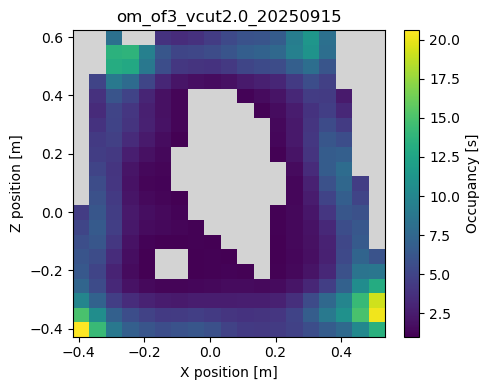

In [69]:
import matplotlib.cm as cm
save=True

plt.figure(figsize=figsize) #TOF(5,4) BOF (5,6)
cmap = cm.viridis.copy()
cmap.set_bad(color='lightgrey')  # NaNs will be shown as light grey
plt.imshow(
    occupancy_smooth_masked.T, 
    origin='lower', 
    extent=(x_edges[0], x_edges[-1], z_edges[0], z_edges[-1]),
    aspect='auto',
    cmap=cmap,
)
plt.colorbar(label='Occupancy [s]')
plt.xlabel('X position [m]')
plt.ylabel('Z position [m]')
filename = f'om_{trial_key}_vcut{speed_cutoff*100}_{date}'
plt.title(filename)
plt.tight_layout()

if save:
    plt.savefig(pf_path / f"{filename}.png", dpi=300, bbox_inches='tight')
plt.show()

### 5. Compute spike map for each cell

In [70]:
spike_maps = {}

for cell_id, spike_idxs in spikes_resampled.items():
    # Keep only spikes during movement
    spike_idxs_moving = spike_idxs[spike_idxs < len(movement_mask)]
    spike_idxs_moving = spike_idxs_moving[movement_mask[spike_idxs_moving]]

    # Get corresponding positions of spikes
    spike_x = x[spike_idxs_moving]
    spike_z = z[spike_idxs_moving]

    spike_count_map, _, _ = np.histogram2d(spike_x, spike_z, bins=[x_edges, z_edges])
    
    # Smooth
    spike_map_smooth = gaussian_filter(spike_count_map, sigma=sigma)
    spike_map_smooth_masked = np.where(occupancy_mask, np.nan, spike_map_smooth)

    spike_maps[cell_id] = spike_map_smooth_masked

pf_data_dict['sm'] = spike_maps

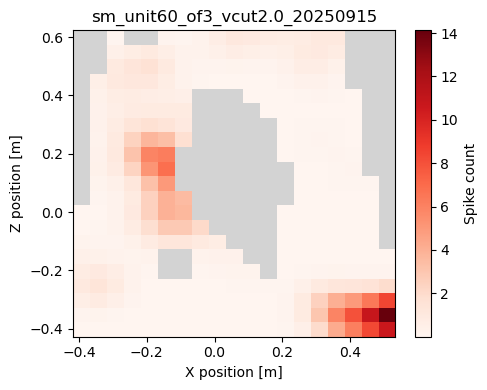

In [71]:
save=True

for unit in spike_maps.keys():

    spike_map = spike_maps[unit]

    plt.figure(figsize=figsize)

    cmap = cm.Reds.copy()
    cmap.set_bad(color='lightgrey')  # for unvisited bins
    plt.imshow(
        spike_map.T, 
        origin='lower', 
        extent=(x_edges[0], x_edges[-1], z_edges[0], z_edges[-1]),
        aspect='auto',
        cmap=cmap,
    )
    plt.colorbar(label='Spike count')
    plt.xlabel('X position [m]')
    plt.ylabel('Z position [m]')
    filename = f'sm_unit{unit}_{trial_key}_vcut{speed_cutoff*100}_{date}'
    plt.title(filename)
    plt.tight_layout()

    if save:
        plt.savefig(pf_path / f"{filename}.png", dpi=300, bbox_inches='tight')
    if unit == list(spike_maps.keys())[0]:
        plt.show()
    plt.close()

### 6. Computre place fields (rate maps)

In [72]:
place_fields = {}
for cell_id, spike_map_smooth_masked in spike_maps.items():
    rate_map = spike_map_smooth_masked / occupancy_smooth_masked
    place_fields[cell_id] = rate_map

pf_data_dict['rm'] = place_fields

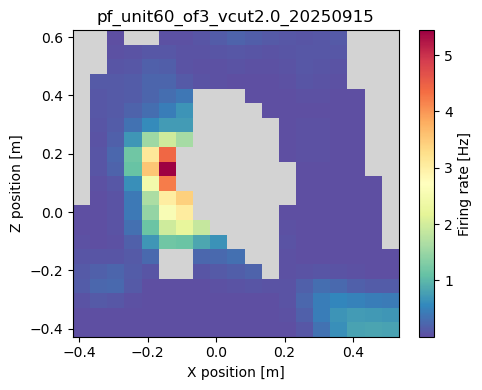

In [73]:
save=True

for unit in place_fields.keys():
    place_map = place_fields[unit]
    plt.figure(figsize=figsize)
    cmap = cm.Spectral_r.copy()
    cmap.set_bad(color='lightgrey')  # for unvisited bins
    plt.imshow(
        place_map.T, 
        origin='lower', 
        extent=(x_edges[0], x_edges[-1], z_edges[0], z_edges[-1]),
        aspect='auto',
        cmap=cmap,
    )
    plt.colorbar(label='Firing rate [Hz]')
    plt.xlabel('X position [m]')
    plt.ylabel('Z position [m]')
    filename = f'pf_unit{unit}_{trial_key}_vcut{speed_cutoff*100}_{date}'
    plt.title(filename)
    plt.tight_layout()
    if save:
        plt.savefig(pf_path / f"{filename}.png", dpi=300, bbox_inches='tight')
    if unit == list(place_fields.keys())[0]:
        plt.show()
    plt.close()

In [74]:
with open(f"{pf_path}/pf_data_dict_{trial_key}_{date}.pkl", "wb") as f:
    pickle.dump(pf_data_dict, f)